TODO:
3. New images in images directory / check R Spark UI
4. References to other pages
5. sort out exercises
6. How does one get to Spark UI on GCP

# Spark Application and UI

This notebook introduces the structure of a Spark application and how the structure relates to the various pages within the application monitoring interface, the Spark UI. 

The Spark UI is used to monitor the status and resource consumption of your Spark cluster and is the main tool for troubleshooting inefficient Spark code. 

Understanding the structure of a Spark application helps to understand how Spark works so you can begin to think differently as you code to get the most out of Spark.

## Spark Application Overview
A Spark application has an underlining structure and learning about this structure will help us
1. understand the difference between a narrow transformation, wide transformation and an action, 
2. navigate around the Spark UI

Below is a diagram of the Spark application hierarchy.

- **Application** - a set of jobs managed by a single driver, e.g. on a Cloudera platform that is the CDSW session. An application is created when we connect to Spark with a `SparkSession` in PySpark or `spark_connect()` in sparklyr.
- **Job** - a set of stages executed as a result of an *action*, e.g. `.count()`/`sdf_nrow()`. A job might consist of a number of *transformations*, but a job always finishes with an *action*.
- **Stage** - a set of tasks that can be executed in parallel. Similar to how *actions* define a job boundary, a stage boundary is created by a *wide* transformation, such as `.groupby()`/`group_by()` or `.join()`/`left_join()`. A stage might consist of many *narrow* transformations, but a stage always finishes with a *wide* transformation.
- **Task** - an individual unit of work assigned to a single core on an executor.
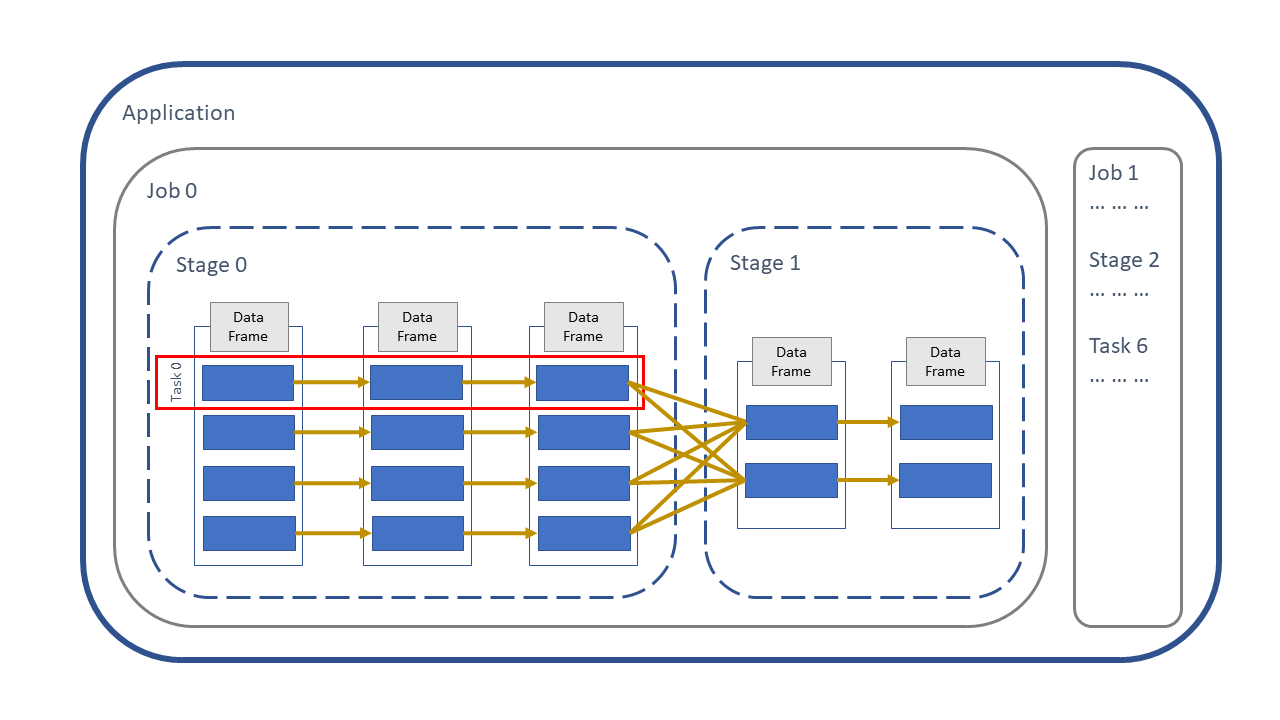


Note that Jobs, Stages and Tasks are numbered starting from zero.

Now look more closely at the DataFrame. On the left there is a Spark DataFrame which is split up into four sections, called *partitions*. Spark puts our data into partitions automatically so we don't have to decide how or when to do it. More details on exactly how Spark does this are in the **Partitions Notebook**. 

The first operation to be applied to this DataFrame is a *narrow* transformation, e.g. summing two columns to create a new column. The second operation is again a narrow transformation. These two operations can be run in parallel, because each child partition has only one parent, indicated by the golden arrows.

Then we hit a stage boundary, which means the third operation is a *wide* transformation, e.g. grouping the data or joining with another DataFrame. This is a wide operation because each child partition has multiple parent partitions. This is also an example of *shuffling* the data, more on shuffling in the **Shuffling Notebook**.

There is then another narrow operation on the grouped DataFrame before we run into an *action*, e.g. writing the data to HDFS or a simple count of the rows. 

As we execute the wide and narrow transformations nothing happens to the data at this point, Spark just builds up a plan of what to do with the DataFrame. This plan is a called the execution plan and is set of instructions of how to transform the data from one state to another. An action initiates the execution plan and so this is when the DataFrame is processed. All the previous transformations, along with the action, are put into Spark *jobs* and deployed on the Spark cluster. 

## Investigate the Spark UI

### Create an application

The first step is to create an application. Once we create a Spark application we can look at the Spark UI. If we stop the session using `spark.stop()`/`spark_disconnect()` or stopping the CDSW session, the Spark UI for our application can no longer be accessed.

Let's start with the necesarry imports and create an application.

In [1]:
import os, IPython
import yaml
from pyspark.sql import SparkSession, functions as F

spark = SparkSession.builder.master("local[2]").appName("spark-app-ui").getOrCreate()

```r
library(sparklyr)

default_config <- sparklyr::spark_config()

sc <- sparklyr::spark_connect(
    master = "local[2]",
    app_name = "spark-app-ui",
    config = default_config)
```

The cell below creates a handy button for us to access the Spark UI. Make sure you hold down Ctrl when you click on the link to open the page in a new tab. See the [Cloudera documentation](https://docs.cloudera.com/documentation/data-science-workbench/1-0-x/topics/cdsw_spark_ui.html) for more informaiton on this code.

In [3]:
url = "spark-%s.%s" % (os.environ["CDSW_ENGINE_ID"], os.environ["CDSW_DOMAIN"])
IPython.display.HTML("<a href=http://%s>Spark UI</a>" % url)

```r
library("cdsw")
url = paste("spark-", Sys.getenv("CDSW_ENGINE_ID"), ".", Sys.getenv("CDSW_DOMAIN"), sep="")
html(paste("<a href=http://", url, ">Spark UI</a>", sep=""))
```

If you follow the above link you will see something silimar to the screenshot below, with the application name on the top right and various tabs along the top. 

There is lots of useful information in the Spark UI, but for this notebook we will only concentrate on the *Jobs* and *Stages* tabs. Note that we haven't executed any *Jobs* yet, so there isn't much to see at the moment.

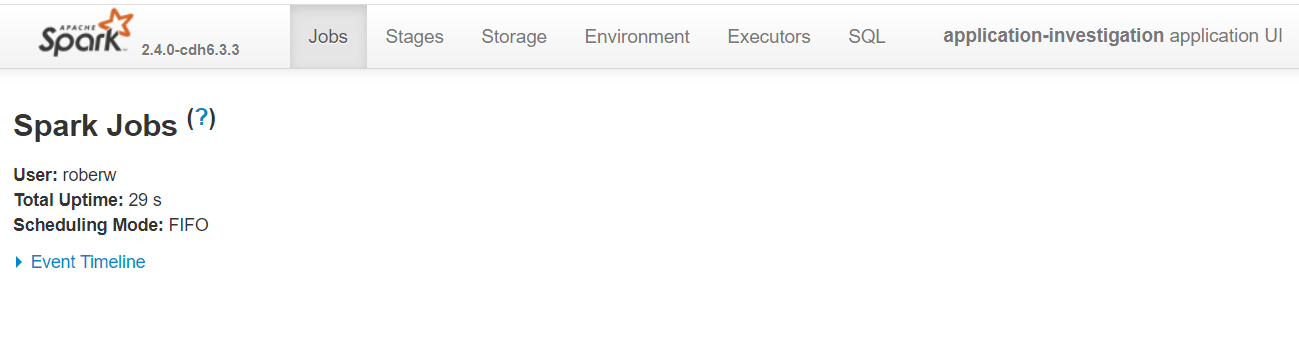

Let's import the animal rescue data and find out the number of partitions in which our `rescue` DataFrame is processed. The number of partitions will be useful for later when we're investigating our application's tasks.

In [4]:
with open("../../../config.yaml") as f:
    config = yaml.safe_load(f)
    
rescue_path = config["rescue_path"]
rescue = spark.read.parquet(rescue_path)

print("Number of partitions: ",rescue.rdd.getNumPartitions())

Number of partitions:  2


```r
config <- yaml::yaml.load_file("ons-spark/config.yaml")

rescue <- sparklyr::spark_read_parquet(sc, config$rescue_path)

print(paste0("Number of partitions: ", sparklyr::sdf_num_partitions(population)))
```

Next we'll carry out some basic processes to see how this translates into jobs, stages and tasks in the Spark UI. We will create a new column to group the incident costs by creating a new column called `cost_group` containing three groups `small`, `medium` and `large`.

In [5]:
rescue = (
    rescue.withColumn("cost_group",
                      F.when(F.col("total_cost")<300, "small")
                      .when((F.col("total_cost")>=300) & (F.col("total_cost")<900), "medium")
                      .when(F.col("total_cost")>=1000, "large")
                      .otherwise(None)
                     )
)

rescue.select("animal_group", "description", "total_cost", "cost_group").show(10, truncate=80)

+------------+----------------------------------------------------------------+----------+----------+
|animal_group|                                                     description|total_cost|cost_group|
+------------+----------------------------------------------------------------+----------+----------+
|         Cat|                                         CAT TRAPPED IN BASEMENT|     290.0|     small|
|       Horse|                                           HORSE TRAPPED IN GATE|     590.0|    medium|
|        Bird|PIGEON WITH WING IMAPLED ON SHARP IMPLEMENT  UNDER A BRIDGE NEAR|     326.0|    medium|
|         Cat|                          ASSIST RSPCA WITH CAT STUCK ON CHIMNEY|     295.0|     small|
|         Dog|                                       DOG FALLEN INTO THE CANAL|     260.0|     small|
|        Deer|                                          DEER STUCK IN RAILINGS|     520.0|    medium|
|        Deer|                                           DEER TRAPPED IN FENCE|   

```r
rescue <- (
    rescue %>% mutate(
        cost_group=case_when(total_cost<300 ~ "small",
                             total_cost>=300 & total_cost<900 ~ "medium",
                             total_cost>=900 ~ "large",
                             TRUE ~ NULL)
    )
)

(
    rescue %>% 
    select("animal_group", "description", "total_cost", "cost_group")
    %>% head(10)
)
```

To produce the above `.show()`/`head()` Spark didn't need to process all of the partitions, there are enough rows on one partition to create the output so Spark only processed one partition. If we want Spark to process all of the partitions we need to call an action that involves all rows of the DataFrame, such as `.count()`.

In [6]:
rescue.count()

5898

```r
rescue %>% sdf_nrow()
```

### Application Event Timeline
Now that we've created some jobs let's have a quick look at the application's *Event timeline*. 

1. Go into the Spark UI
2. Make sure you're on the Jobs tab
3. Open the *Event timeline* collapsable section using the blue arrow to see something similar to the below image.

Note the images in this notebook were created using PySpark, the Spark UI will look slightly different when using sparklyr, but not very different.

In the top section of the timeline you will see the executors being added and removed by the *dynamic allocation* feature of Spark. The jobs are shown in the bottom section of the timeline. Hover over a job in the timeline and the corresponding job in the *Completed Jobs* table below will be highlighted.

*Tip:* You can tick the *Enable Zooming* button to zoom in and out of different sections of the timeline

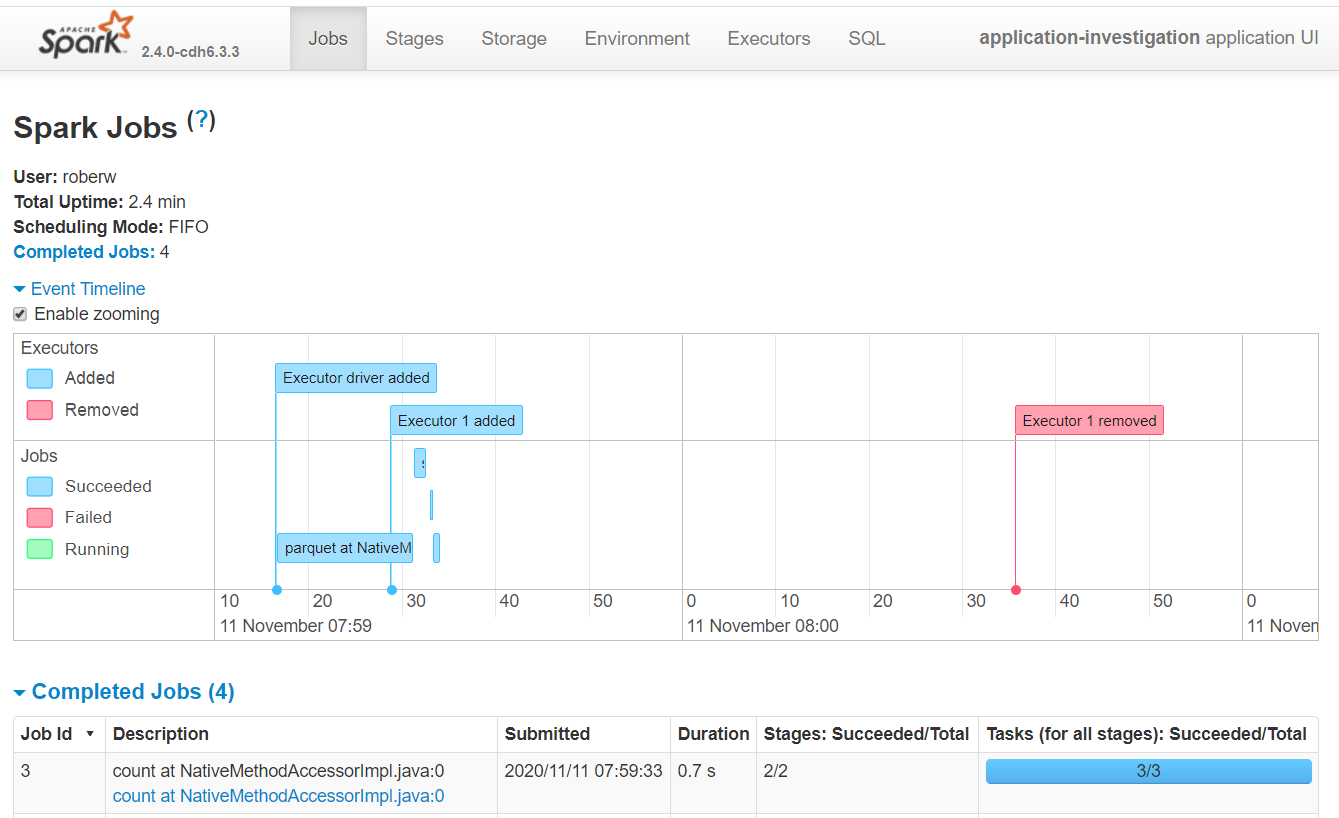

### Job details: stage information
Let's look at the *Completed Jobs* table. The first job was to interact with HDFS, with a description `parquet at NativeMethodAccessorImpl.java:0`. Spark needs to know the DataFrame's schema, i.e. column names and types, to validate our PySpark/sparklyr code. This will always create a job, usually consisting of just one stage as shown in the *Stages* column.

The second job was initiated by `.show()`/`head()`, again it consists of one stage, which itself had one task as shown in the *Tasks* column. As mentioned in the previous section, Spark only needed to process one partition to produce the output so we therefore have one task. 

The third job was the `.count()`/`sdf_nrow()`. The job contains two stages, which themselves consist of 3 tasks. Let's get more information on these stages and tasks. Within the *Completed Jobs* table click on the link in the *Description* column for the latest job that says `count at NativeMethodAccessorImpl.java:0`. 

Now we are on the *Job Details* page which show information about the job's stages. The first stage had two tasks, one task to count the rows in each partition. The second stage had one task, which was to send the result to the driver for us to see. On this page you will see another type of diagram called a Directed Acyclic Graph or DAG, by opening the *DAG Vizualisation* collapsable section.

The DAG shows the two stages. Here are some rough definitions of the terms inside the boxes
1. *WholeStageCodegen*- this is Spark creating an optimised version of our code
2. *Exchange* - another word for *shuffling* data, i.e. data is being moved between partitions
3. *mapPartitionsInternal* - bringing information from multiple partitions together

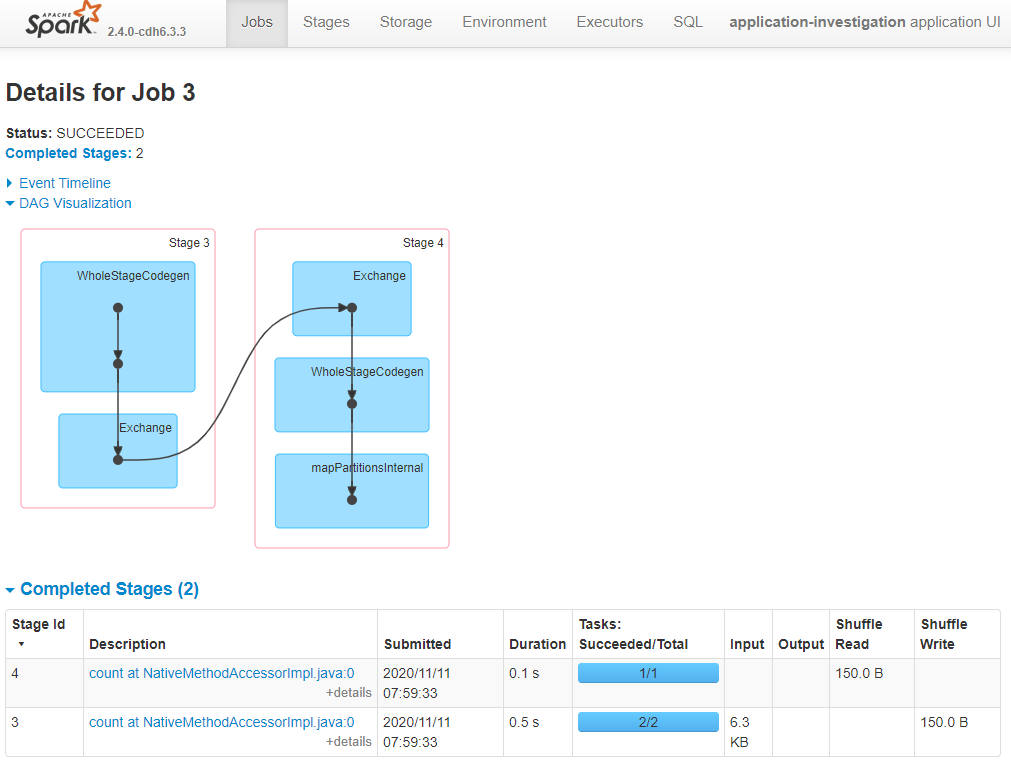

### Stage details: task information

From the *Completed Stages* table on the *Job Details* page, click on the link in the *Description* column for the stage consisting of two tasks (Stage Id 3 in the example above). 

Here you will find the *Stage Details* page that contains lots of detailed information about the individual tasks and is one of the more useful places to look for troubleshooting sluggish applications. We will just concentrate on two sections within this page, the *Event timeline* (for tasks) and the *Summary Metrics*.

#### Task Event timeline

Open the *Event timeline* collapseable menu to see the below image. The timeline has a single row, which means one executor was used to complete these tasks. The executor ID in this case was `cdhwn-d01-06.ons.statistics.gov.uk`. This executor has a single core, we know this because the *Executor Computing Time* (shown in green) for the first task had finished before the second task started. If there were two cores on this executor the two tasks could have ran in parallel, at the same time.

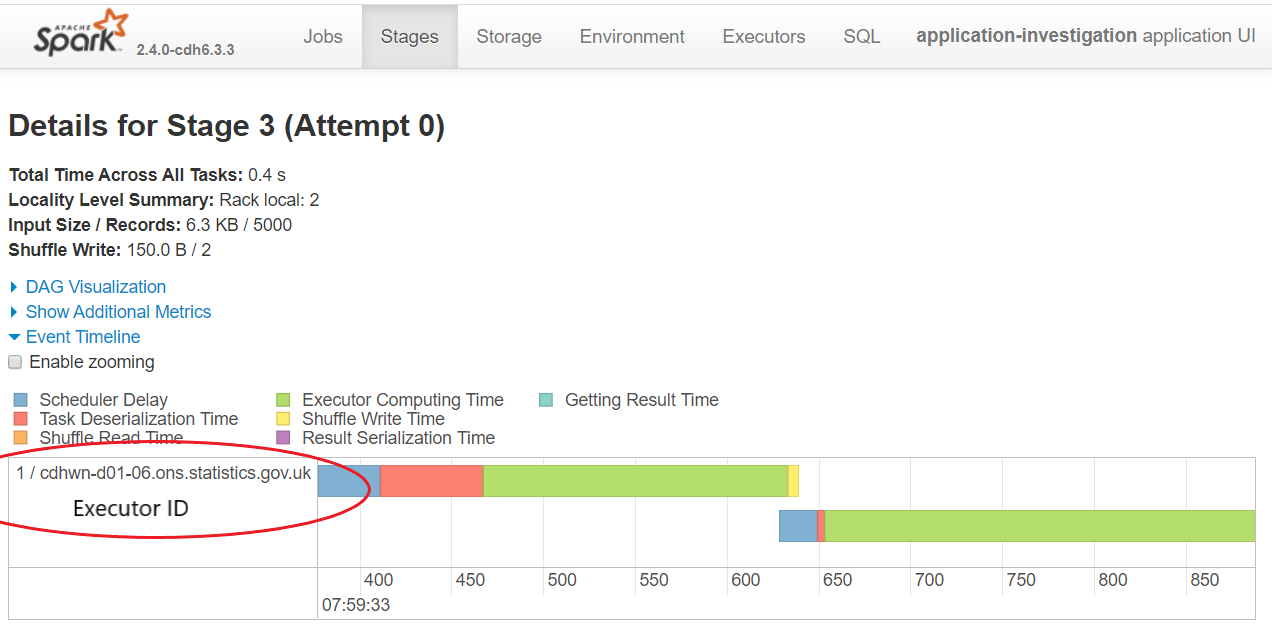

The colours also indicate what was going on while the task was being completed. In general- green is good, and is an indication that there is no need worry or spend time optimising the processing. Delays often occur when lots of data are moved around, because the process can involve some or all of the below:
1. serialising data - preparing the data to be moved to disk
2. shuffle write - writing data to disk to be read by a shuffle somewhere else
3. shuffle read - reading a shuffle from disk onto an executor or driver
4. deserialisation - preparing the data to be read in memory

Sometimes when processing many small partitions more time is spent on moving small amounts of data around than useful processing time. This task event timeline will show evidence of this problem in the form of non-green colours. We'll see this in action later.

#### Summary Metrics

Summary information about the tasks within a stage are given in the Summary Metrics table. Select the *(De)select All* option to view more metrics.

This is a useful indication of the distribution of times taken for various components of task processing. It might not be the most useful part of the UI to look at with only two tasks, so we will revisit this later.

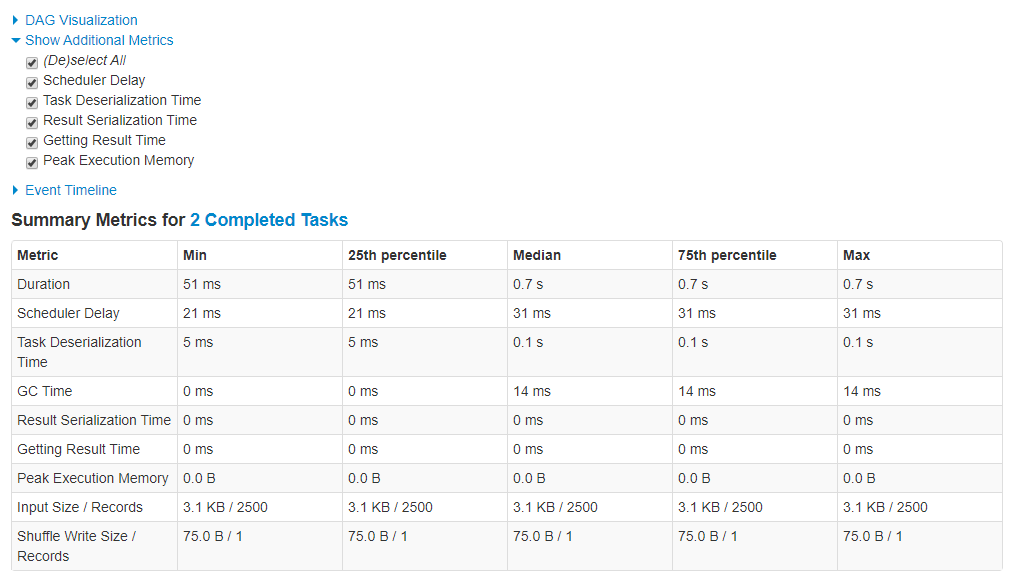

We won't discuss *GC time*, or garbage collection time, in this notebook. This is a topic that is covered in **a separate article**.

## More information

### Documentation

There are tens of blogs available online that introduce some feature in the Spark UI, but most are not particularly useful and are generally rehashes of other blogs. 

Finally, since its release of version 3.0.0, Spark's online documentation contains information about the [Spark web UI](https://spark.apache.org/docs/latest/web-ui.html). Note however that this is a later version of Spark than what is currently used in DAP at the ONS. Therefore there will be some small differences between what you see in your application's UI and that documented in the above link. 

The documentation runs through the different pages of the Spark UI with screenshots and a brief description of the various elements. It's a good place to start and useful for defining terminology. For example, if you want to know what *Scheduler delay* means, search for this term on the docs page and you will find, 

>**Scheduler delay** is the time the task waits to be scheduled for execution

### Moving data to the driver

Note that in our case using the Data Access Platform (DAP) we could call the *driver* here *CDSW session*, but we'll use driver to be consistent with other material in this book.

What can the Spark UI tell us about processes that run on the driver? Let's investigate by 
1. aggregate the `population` DataFrame
2. use `.toPandas()`/`collect()` to move the data to the driver
3. make a plot of the aggregated data
4. check the Spark UI

First step is to aggregate the data, we'll find the count of incidents in each `cost_group`. We will distinguish between the Spark and Pandas DataFrames using `_spark` or `_pandas` as suffixes respectively.

In [18]:
aggregated_spark = rescue.groupBy("cost_group").agg(F.count("incident_number").alias("count"))

#import pandas as pd
aggregated_pandas = aggregated_spark.toPandas()

aggregated_pandas

,cost_group,count
0,None,82
1,medium,2045
2,small,3691
3,large,80


```r
aggregated_spark <- rescue %>% group_by(cost_group) %>% summarise(count=n())

aggregated_r <- aggregated_spark %>% collect()

aggregated_r
```

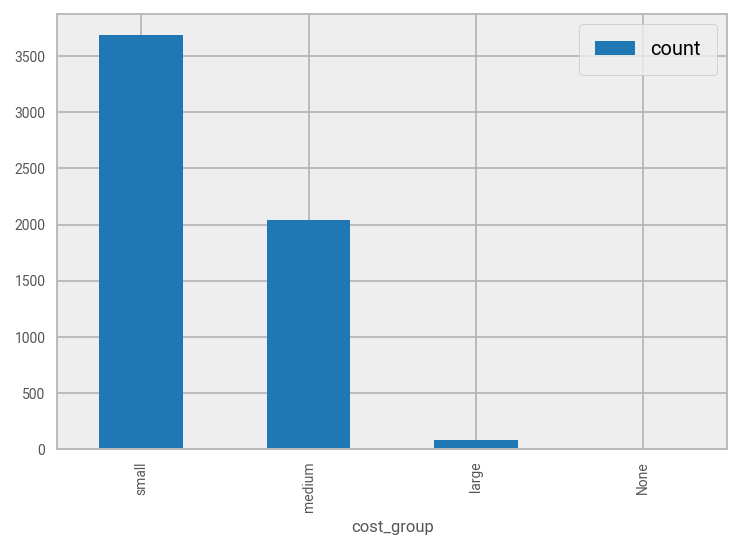

In [19]:
aggregated_pandas = aggregated_pandas.set_index("cost_group").loc[["small", "medium", "large", "None"]]
aggregated_pandas.plot(kind="bar")

```r
aggregated_r <- aggregated_spark %>% collect() %>% arrange(desc(cost_group))

library(ggplot2)
(
    ggplot(aggregated_r, aes(cost_group, count))
    +geom_bar(stat="identity")
)
```

Now we have our chart, let's see how that translates to tasks in the Spark UI.

There is a job for `.toPandas()`/`collect()`, but nothing after that for the plot. Why? 

The plotting was done in Pandas/R and so Spark was not involved at all. We therefore don't expect the Spark UI to show anything that represents those processes.

### Improving performance

Finally, let's take a look at the stages and tasks for the latest job in the Spark UI and have and see an example of identifying a performance issue, how to solving it, an viewing evidence of improvement.

The `.toPandas()`/`collect()` job has two stages because the `.groupBy().agg()`/`group_by()%>%summarise()` command is a wide transformation. In the first stage the data is read in, a new column added and then the dataset is aggregated. This stage has 2 tasks because the `rescue` DataFrame has 2 partitions. The second stage in this job moves the data from the cluster to the CDSW session. This stage has 200 tasks, because `aggregated_spark` has 200 partitions, more on why this is the case in the **Partitions notebook**. A screenshot of the *Stage details* for these tasks is below.

![image.png](attachment:image.png)

Two executors were used this time to complete the 200 tasks. These 200 tasks seem to show relatively poor performance. This is indicated by the non-green colours in the timeline and by comparing the *Duration* (useful processing time) metrics with that of *Scheduler Delay* and *Task Deserialization Time* in the *Summary Metrics* table. Would we get better performance if the `aggregated_spark` DataFrame had fewer partitions? Let's try to improve the performace by reducing the number of partitions from 200 to 2.

In [16]:
aggregated_spark = rescue.groupBy("cost_group").agg(F.count("incident_number").alias("count")).coalesce(2)
aggregated_pandas = aggregated_spark.toPandas()

```r
aggregated_spark <- (
    rescue %>% group_by(size_group)
    >%> summarise(count=n())
    >%> sdf_coalesce(2)
)

aggregated_r <- aggregated_spark %>% collect()
```

Now navigate to the details of the latter stage of the latest job within the UI and you will see something similar to the screenshot below. Of course, the all important metric to compare is the time taken to complete the stage. Previously, using 200 partitions the stage time was 2 seconds, using 2 partitions the stage time was 0.9 seconds. Looking at this page we can see why.

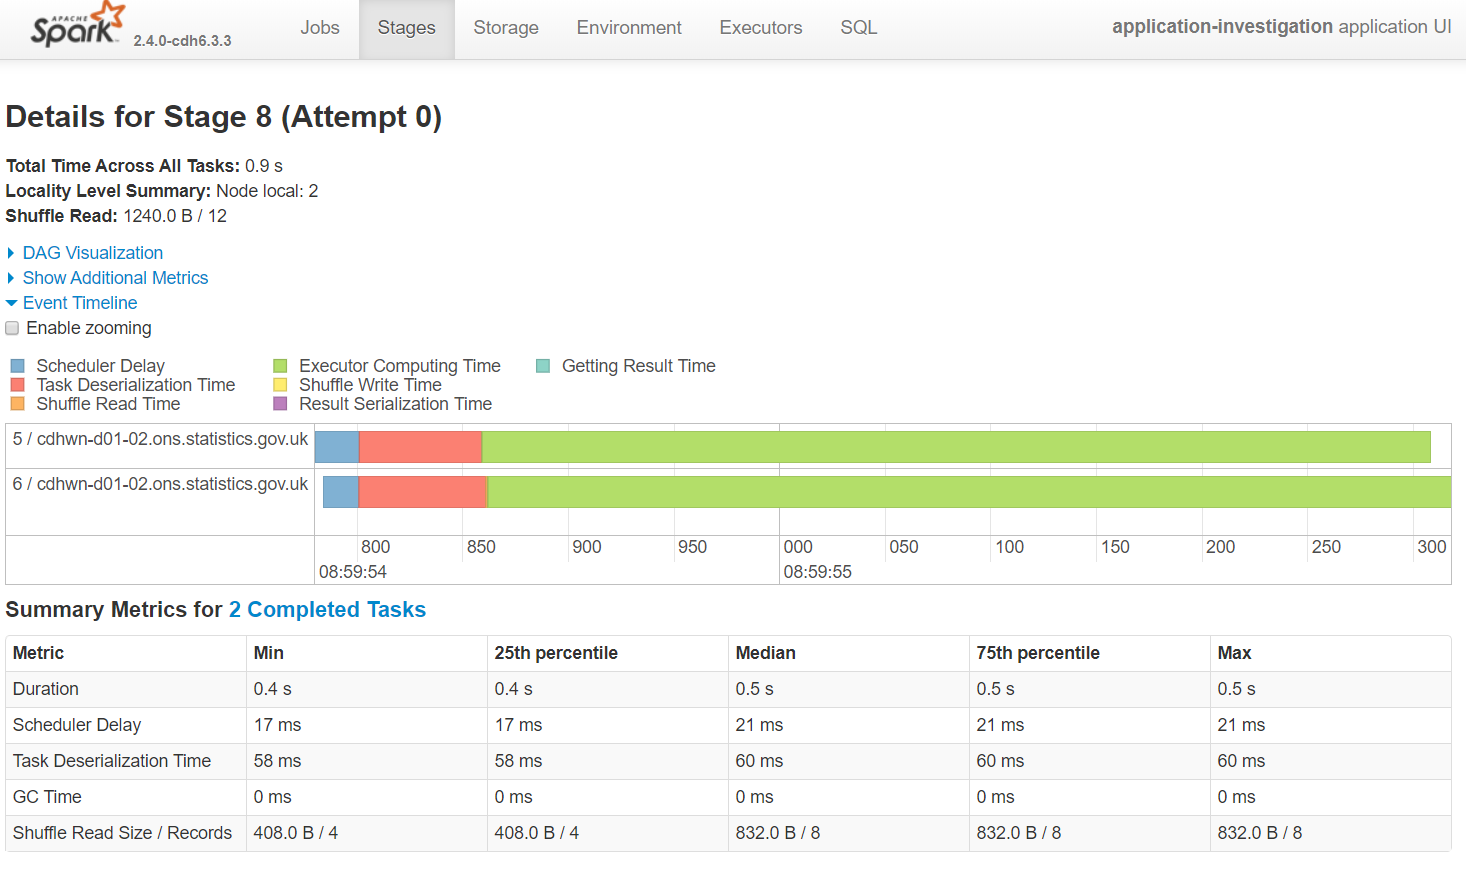

Again, two executors were used, but just one task per executor. There's much more green visible in this timeline and comparing *Scheduler Delay* and *Task Deserialization Time* with *Duration* in the *Summary Metrics* tells a very different story.

To conclude - previously a lot of time was spent scheduling tasks and (de)serializing data. By having a smaller number of bulkier partitions we spent more time on useful processing and decareased the overall processing time.

## Summary

**Spark application hierarchy**

    - Application 
        - Job 
            - Stage 
                - Task


**Use the Spark UI to**
- debug slow or crashing applications
- investigate what Spark is doing "under the hood"


**Tips**
- Look out for task colours, green is good
- Use online documentation for more information about the UI
- Lots of small partitions is an inefficient strategy to process data
- Matching up the executed code with the job number in the UI is difficult, the description starts with the action used to initiate that job. You can also customise the [job description](http://np2rvlapxx507/DAP_CATS/troubleshooting/tip-of-the-week/blob/master/tip_14_setJobDescription.ipynb) to track jobs easier.

## Exercises

1. In the [Task Event timeline](#Task-Event-timeline) section it was stated that "if each executor within this Spark session had two cores the two tasks would run in parallel". Test this. 

    Stop the Spark session using `spark.stop()` and re-run this notebook but this time with two cores on each executor. 
        a) Is the above statement true? 
        b) Did this stage take less time with the extra core? 
        c) Would increasing the cores from two to three per executor improve performance?
    
    *Tip: When running the notebook a second time run all the cells in order to get the same stage number (Stage 3)*
    

2. We showed that Spark DataFrames are monitored by the Spark UI but Pandas DataFrames are not. What about Koalas? If you haven't heard of koalas have a look at [this guidance on the ONS Data Service Hub](https://officenationalstatistics.sharepoint.com/sites/DatCapDatSer/SitePages/Koalas%20comparison.aspx). 

    Have a think about it first. Then import koalas as demonstrated in the above link, convert the Spark DataFrame to Koalas using,
    
    `sex_age_group_count_koalas = ks.DataFrame(sex_age_group_count_spark)`
    
    and create `age_group_count_by_sex_koalas` using the same syntax as was used to create `age_group_count_by_sex_pandas` (remember to apply `.pivot_table()` to the Koalas DataFrame as opposed to the Spark DataFrame).
    
    **Bonus question** on this exercise - does the ordering work? i.e. `.loc[age_order]` or `.loc[age_order[::-1]`

In [18]:
# Solution 1

# Step 1
# spark.stop() to stop the current Spark session

# Step 2
# Change .config("spark.executor.cores", 1) to .config("spark.executor.cores", 2) within the SparkSession.builder

# Step 3
# Run the whole notebook again

# Step 4
# Check the task Event timeline for Stage 3 in the Spark UI
# a) Yes! It did work. 
# b) As shown in the notebook, Stage 3 using one core took 0.6s.
#    Running the notebook with two cores gave 0.4s for Stage 3.
#    Note that due to the nature of distributed computing you might get different answers each time you run the notebook.
# c) Assuming the people DataFrame consists of two partitions, 
#    increasing cores from two to three per executor would **not** improve performance for this stage. 
#    Two partitions translates to two tasks for this stage, therefore there would be one redundant core. 

In [19]:
# Solution 2
import databricks.koalas as ks

sex_age_group_count_koalas = ks.DataFrame(sex_age_group_count_spark)

age_group_count_by_sex_koalas = sex_age_group_count_koalas.pivot_table(
    columns="sex", index=["age_group"], values=("count")
).loc[age_order[::-1]]

print(age_group_count_by_sex_koalas)

print("\nUsing .loc[] to modify order:")

print(age_group_count_by_sex_koalas.loc[age_order])

print("\nLooks like using .loc[] to specify order does not work with Koalas")

sex        female   male
age_group               
<30         732.0  742.0
>60         965.0  990.0
30-60       779.0  792.0

Using .loc[] to modify order:
sex        female   male
age_group               
<30         732.0  742.0
>60         965.0  990.0
30-60       779.0  792.0

Looks like using .loc[] to specify order does not work with Koalas
